# Imports

In [2]:
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import leastsq,minimize
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve as convolve
from common import numerics as num
from common import plotting

Trouble building custom colormaps!


# Generate test data

## Load test interferogram

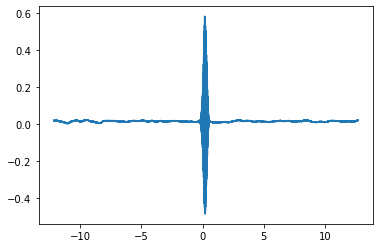

In [26]:
interferogram0,x=np.loadtxt('interferogram_test.txt')
interpolator0=interp1d(x=x,y=v,bounds_error=False,fill_value='extrapolate',assume_sorted=False)
plt.plot(x,interferogram0)
#plt.xlim(0,1)

## Shifted interferograms

In [520]:
def shifted_interferogram(dx,noise=.01):
    
    to_x=x-dx
    interferogram_shifted = interpolator0(to_x)
    interferogram_shifted = AWA(interferogram_shifted,
                                adopt_axes_from=interferogram0)
    interferogram_shifted += noise*np.random.randn(len(interferogram_shifted))
    
    return interferogram_shifted

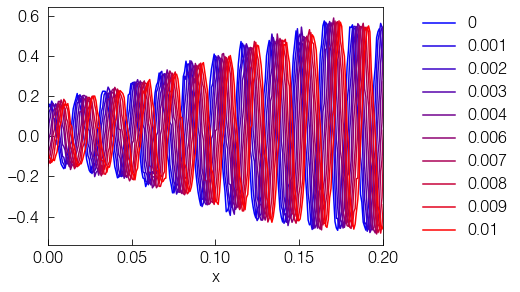

In [521]:
N=10
dxs_correct=.01*np.linspace(0,1,N)
colors=plotting.bluered_colors(N)

interferograms=[shifted_interferogram(dx) for dx in dxs_correct]

for i,ifg in enumerate(interferograms):
    ifg.plot(label='%1.1G'%dxs_correct[i],
            color=next(colors),alpha=1)
plt.xlim(-0,.2)
plt.legend(loc=(1.1,0))

# De-shifting routine

## Envelope extractor

In [440]:
N=len(interferogram0)
fs = np.fft.fftfreq(N)
w=np.blackman(N)

def extract_env(interferogram,Nwavelengths=10): #smooth over `Nwavelengths`

    interferogram = np.array(interferogram)
    interferogram -= np.mean(interferogram)
    s = np.abs(np.fft.fft(interferogram*w))
    t=time.time()
    f0 = np.abs(fs[np.argmax(s)]) #in case we pick up a negative frequency, doesnt matter

    sw = np.exp(1j*2*np.pi*f0*np.arange(N))
    window_len = np.pi/(f0)*Nwavelengths
    window = np.blackman(window_len)
    interferogram_env=convolve(interferogram*sw,
                                 window,mode='same')
    interferogram_env = np.abs(interferogram_env)
    
    
    
    return interferogram_env

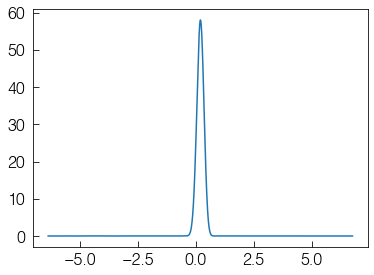

In [441]:
env0 = extract_env(interferogram0)
plt.plot(x_reg,env0)

0.0056145336629436216
0.005555555555555556


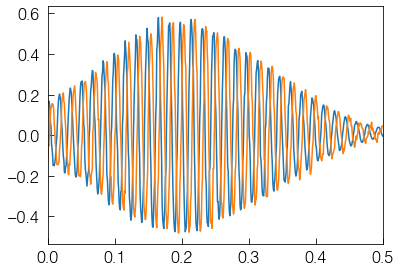

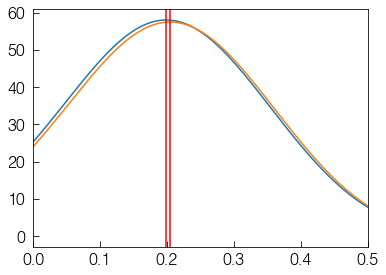

In [442]:
i=5
dx_correct=dxs[i]

intfg = interferograms[i]
plt.plot(x_reg,interferogram0,
         x_reg,intfg)
plt.xlim(0,.5)

env = extract_env(intfg)
plt.figure()
plt.plot(x_reg,env0,x_reg,env)

#plt.ylim(0,100)
#plt.ylim(.2,.27)
plt.xlim(0,.5)

x0=x_reg[np.argmax(env0)]
x1=x_reg[np.argmax(env)]
print(x1-x0)
plt.axvline(x0,color='r')
plt.axvline(x1,color='r')
print(dx_correct)

## Envelope comparator

In [449]:
env0=extract_env(interferogram0)

def get_dx(interferogram,interferogram0=None,env0=None,p=3):
    
    global env
    if env0 is None: env0=extract_env(interferogram0)
    env = extract_env(interferogram)
    
    x0=np.sum(x_reg*env0**p)/np.sum(env0**p)
    x1=np.sum(x_reg*env**p)/np.sum(env**p)
    
    return x1-x0

time elapsed on 0: 0.004958152770996094
time elapsed on 1: 0.0054111480712890625
time elapsed on 2: 0.0046389102935791016
time elapsed on 3: 0.004542112350463867
time elapsed on 4: 0.004960060119628906
time elapsed on 5: 0.005199909210205078
time elapsed on 6: 0.004702091217041016
time elapsed on 7: 0.00474095344543457
time elapsed on 8: 0.004927873611450195
time elapsed on 9: 0.004759788513183594


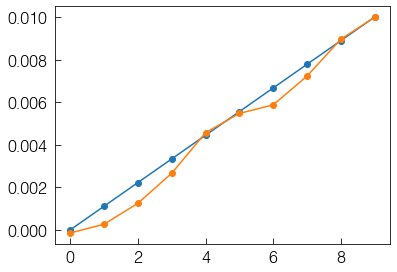

In [450]:
dxs_inferred=[]
for i,intfg in enumerate(interferograms):
    
    t0=time.time()
    
    dx = get_dx(intfg,env0=env0)
    dxs_inferred.append(dx)
    print('time elapsed on %i:'%i,time.time()-t0)
    
plt.plot(dxs_correct,marker='o')
plt.plot(dxs_inferred,marker='o')

In [ ]:
%timeit get_dx(intfg,env0=env0);

## Even finer optimizer (not needed)

In [273]:
i=5
dx_guess=dxs_inferred[i]
intfg=interferograms[i]
env = extract_env(intfg)
env_interpolator = interp1d(x=x_reg,y=env,axis=0,bounds_error=False,
                            fill_value='extrapolate',assume_sorted=True)

def to_minimize(args):
    dx=args[0]
    
    env_shifted = env_interpolator(x_reg+dx)
    
    return env0 - env_shifted

def to_minimize2(args):
    dx=args[0]
    
    inftg0_shifted = interpolator0(x_reg-dx)
    
    return intfg - inftg0_shifted

In [274]:
print('dx correct',dxs_correct[i])
print('dx inferred',dx_guess)
dx_min=leastsq(to_minimize,(dx_guess,))[0][0]
print('dx min',dx_min)
dx_min=leastsq(to_minimize2,(dx_guess,))[0][0]
print('dx min 2',dx_min)

dx correct 0.005555555555555556
dx inferred 0.005684347698119069
dx min 0.005614642931949752
dx min 2 0.005477540583240862


# Put it all together

In [174]:
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import leastsq,minimize
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve as convolve
from common import numerics as num
from common import plotting

class InterferogramAligner(object):
    
    def regularize_intfgs(self, intfgms_arr):

        assert len(intfgms_arr) % 2 == 0
        Nintfgms = len(intfgms_arr) // 2

        xmins = []
        xmaxs = []
        Nxs = []
        interps = []
        for i in range(Nintfgms):
            y, x = np.array(intfgms_arr[2 * i:2 * i + 2])
            N = len(x)
            x = x[:N // 2]
            y = y[:N // 2]
            where_valid = (x != 0) * np.isfinite(x) * np.isfinite(y)
            x = x[where_valid]
            y = y[where_valid]
            x,y=zip(*sorted(zip(x,y)))
            x=np.array(x); y=np.array(y)

            p = np.polyfit(x,y, deg=3)
            y -= np.polyval(p, x=x)
            xmins.append(x.min())
            xmaxs.append(x.max())
            Nxs.append(len(x))
            interp = interp1d(x=x, y=y, bounds_error=False,
                              fill_value=0, assume_sorted=True)  # 'extrapolate')
            interps.append(interp)

        # build a regular grid, with Npoints a sufficiently large power of 2
        p = 1
        Nmax = np.max(Nxs)
        while 2 ** p < Nmax: p += 1
        Nx = 2 ** (p + 1)
        self.x_reg = np.linspace(np.max(xmins), np.min(xmaxs), Nx)
        self._interferograms = [interp(self.x_reg) for interp in interps]
        self._interferogram_interps = interps
        
    def get_xs(self): return self.x_reg.copy()
        
    def get_intfgms(self): return self._interferograms.copy()
    
    def get_intfgm0(self): return self._interferograms[0].copy()
    
    def interp_intfgm(self,i,x_new):
        
        interp = self._interferogram_interps[i]
        return interp(x_new)
            
    def __init__(self, intfgms_arr):
        
        self.regularize_intfgs(intfgms_arr)
    
    def extract_env(self,interferogram,Nwavelengths=10): #smooth over `Nwavelengths`

        if False in [hasattr(self,attr) for attr in ('Nx','w','fs')]:
            print('stored!')
            self.Nx=len(self.get_xs())
            self.w=1#np.blackman(self.Nx)
            self.fs = np.fft.fftfreq(self.Nx)

        interferogram = np.array(interferogram)
        interferogram -= np.mean(interferogram)
        self.interferogram = interferogram
        s = np.abs(np.fft.fft(interferogram*self.w))
        self.s = s
        f0 = np.abs(self.fs[np.argmax(s)]) #in case we pick up a negative frequency, doesnt matter
        
        sw = np.exp(1j*2*np.pi*f0*np.arange(self.Nx))
        window_len = np.pi/(f0)*Nwavelengths
        window = np.blackman(window_len)
        interferogram_env=convolve(interferogram*sw,
                                     window,mode='same')
        interferogram_env = np.abs(interferogram_env)

        return interferogram_env

    def extract_env(self, interferogram, Nwavelengths=10):  # smooth over `Nwavelengths`

        self.Nx = len(self.get_xs())
        self.w = np.blackman(self.Nx)
        window_len = 1000
        window = np.blackman(window_len)
        interferogram_env = convolve(interferogram**2*self.w,
                                     window, mode='same')
        interferogram_env = np.abs(interferogram_env)

        return interferogram_env
    
    def get_dx(self,interferogram,interferogram0=None,env0=None,
               p=2,**kwargs):
    
        if env0 is None: env0=self.extract_env(interferogram0,**kwargs)
        env = self.extract_env(interferogram,**kwargs)
        x = self.get_xs()

        x0=np.sum(x*env0**p)/np.sum(env0**p)
        x1=np.sum(x*env**p)/np.sum(env**p)

        return x1-x0
    
    def get_dxs(self,*args,p=2,**kwargs):
        
        intfgm0 = self.get_intfgm0()
        intfgms = self.get_intfgms()[1:] #We don't want the "zeroth" one which is our anchor
        
        env0 = self.extract_env(intfgm0,**kwargs)
        dxs=[]
        for intfgm in intfgms:
            
            dx = self.get_dx(intfgm,env0=env0,p=p,**kwargs)
            #print('Inferred dx:',dx)
            dxs.append(dx)
        
        return dxs
    
    def align_intfgs(self,*args,p=2,**kwargs):
        
        dxs = [0]+self.get_dxs(*args,p=p,**kwargs)
        avg_dx = np.mean(dxs)
        
        intfgms_aligned = []
        for i,dx in enumerate(dxs):
            x_new = self.get_xs() + dx - avg_dx
            intfgm_aligned = self.interp_intfgm(i, x_new)
            intfgms_aligned.append(intfgm_aligned)
        
        return intfgms_aligned
    
    def __call__(self,*args,**kwargs):
        
        intfgms_aligned = self.align_intfgs(*args,**kwargs)
        
        return [np.mean(intfgms_aligned,axis=0),
               self.get_xs()]
            

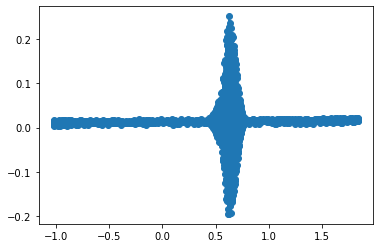

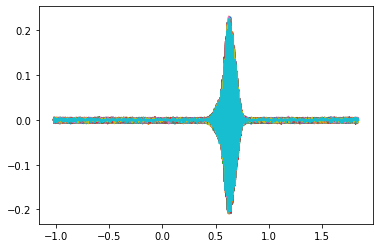

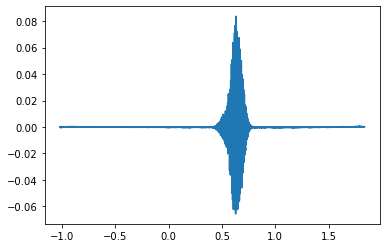

In [175]:
intfgms_arr=np.loadtxt('interferogram_arr.txt')
N=intfgms_arr.shape[1]

x,y=intfgms_arr[1][:N//2],intfgms_arr[0][:N//2]
x,y=zip(*sorted(zip(x,y)))
plt.figure()
plt.plot(x,y,marker='o',ls='-')
#plt.xlim(.8,.95)
    
IA = InterferogramAligner(intfgms_arr)
intfg_aligned,x = IA(Nwavelengths=40,p=2)

plt.figure()
x=IA.get_xs()
for intfg in IA.get_intfgms():
    plt.plot(x,intfg)
#plt.xlim(.8,.85)

plt.figure()
plt.plot(x,intfg_aligned)
#plt.xlim(.8,.85)

(0.6, 0.8)

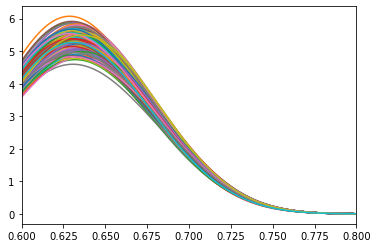

In [176]:
intfgs = IA.get_intfgms()
x=IA.get_xs()
for intfg in intfgs:
    e=IA.extract_env(intfg,Nwavelengths=3)
    plt.plot(x,e)
    
plt.xlim(.6,.8)

## Try out the class

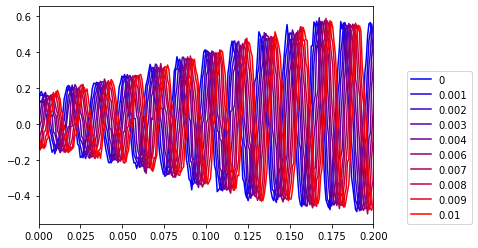

In [28]:
def shifted_interferogram(dx,noise=.01):
    
    to_x=x-dx
    interferogram_shifted = interpolator0(to_x)
    interferogram_shifted += noise*np.random.randn(len(interferogram_shifted))
    
    return interferogram_shifted

N=10
dxs_correct=.01*np.linspace(0,1,N)
colors=plotting.bluered_colors(N)

intfgs_arr=[interferogram0,x_reg]

for i in range(N):
    
    dx = dxs_correct[i]
    intfg_shifted = shifted_interferogram(dx)
    intfgs_arr.append(intfg_shifted)
    intfgs_arr.append(x_reg)
    
    plt.plot(x_reg, intfg_shifted,
             label='%1.1G'%dxs_correct[i],
             color=next(colors),alpha=1)
    
plt.xlim(-0,.2)
plt.legend(loc=(1.1,0))

stored!
Inferred dx: -0.0003884149483543986
Inferred dx: 0.0009234046059979628
Inferred dx: 0.0011044192559284127
Inferred dx: 0.00407674816980666
Inferred dx: 0.005046858204411447
Inferred dx: 0.006369085858598189
Inferred dx: 0.007450362480855288
Inferred dx: 0.007414785973362786
Inferred dx: 0.008526373047355179
Inferred dx: 0.010532429464943649
Alignment time: 0.23041319847106934
Correct dx: 0.0
Correct dx: 0.0011111111111111111
Correct dx: 0.0022222222222222222
Correct dx: 0.003333333333333333
Correct dx: 0.0044444444444444444
Correct dx: 0.005555555555555556
Correct dx: 0.006666666666666666
Correct dx: 0.007777777777777777
Correct dx: 0.008888888888888889
Correct dx: 0.01
Inferred dx: -0.0003884149483543986
Inferred dx: 0.0009234046059979628
Inferred dx: 0.0011044192559284127
Inferred dx: 0.00407674816980666
Inferred dx: 0.005046858204411447
Inferred dx: 0.006369085858598189
Inferred dx: 0.007450362480855288
Inferred dx: 0.007414785973362786
Inferred dx: 0.008526373047355179
Infe

Text(0.5, 1.0, 'Averaged')

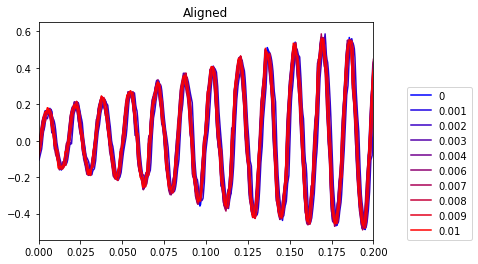

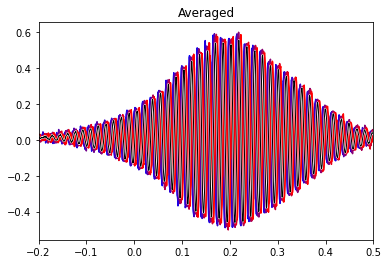

In [29]:
t=time.time()
IA = InterferogramAligner(intfgs_arr)
intfgs_aligned = IA.align_intfgs()
print('Alignment time:',time.time()-t)

for dx in dxs_correct:
    print('Correct dx:',dx)
    
    
colors=plotting.bluered_colors(N)
for i in range(N):
    
    dx = dxs_correct[i]
    intfg_aligned = intfgs_aligned[i+1]
    
    plt.plot(IA.get_xs(), intfg_aligned,
             label='%1.1G'%dxs_correct[i],
             color=next(colors),alpha=1)
plt.xlim(-0,.2)
plt.legend(loc=(1.1,0))
plt.title('Aligned')

plt.figure()  
colors=plotting.bluered_colors(N)
for i in range(N):
    
    dx = dxs_correct[i]
    intfg_shifted = shifted_interferogram(dx)
    
    plt.plot(x_reg, intfgs_arr[2*i],
             label='%1.1G'%dxs_correct[i],
             color=next(colors),alpha=1)
    
intfg_best,x_best = IA()
plt.plot(x_best,intfg_best,color='w',lw=2)
plt.plot(x_best,intfg_best,color='k',lw=1)
plt.xlim(-0.2,.5)
plt.title('Averaged')

In [44]:
pdb off

Automatic pdb calling has been turned OFF


## Try a new version

In [338]:
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import leastsq,minimize
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve as convolve
from common import numerics as num
from common import plotting
from scipy.stats import binned_statistic

class InterferogramAligner2(object):
    
    def regularized_intfg(self, intfgms_arr, fwd=True):

        assert len(intfgms_arr) % 2 == 0
        Nintfgms = len(intfgms_arr) // 2

        all_xs=[]
        all_ys=[]
        for i in range(Nintfgms):
            y, x = np.array(intfgms_arr[2 * i:2 * i + 2])
            N = len(x)
            
            if fwd:
                x = x[:N // 2]
                y = y[:N // 2]
            else:
                x = x[N // 2 :]
                y = y[N // 2 :]
                
            where_valid = (x != 0) * np.isfinite(x) * np.isfinite(y)
            all_xs += list(x[where_valid])
            all_ys += list(y[where_valid])
    
        stat = binned_statistic(all_xs, all_ys,
                                statistic='mean',
                                bins=len(all_xs) // Nintfgms,
                                range=(np.min(all_xs), np.max(all_xs)))

        ynew = stat.statistic
        xnew = stat.bin_edges[:-1]
        keep=np.isfinite(ynew)
        ynew=ynew[keep]
        xnew=xnew[keep]
                                       
        p = np.polyfit(x=xnew,y=ynew,deg=3)
        ynew -= np.polyval(x=xnew,p=p)                               
        
        return ynew,xnew
            
    def __init__(self, intfgms_arr):
        
        intfg_fwd, x_fwd = self.regularized_intfg(intfgms_arr, fwd=True)
        self.interp_fwd = interp1d(x=x_fwd, y=intfg_fwd, bounds_error=False,
                              fill_value=0, assume_sorted=True)
        intfg_bwd, x_bwd = self.regularized_intfg(intfgms_arr, fwd=False)
        self.interp_bwd = interp1d(x=x_bwd, y=intfg_bwd, bounds_error=False,
                              fill_value=0, assume_sorted=True)
                         
        xmin = np.max( (np.min(x_fwd), np.min(x_bwd)) )
        xmax = np.min( (np.max(x_fwd), np.max(x_bwd)) )              
        Nx = np.mean( (len(x_fwd), len(x_bwd)) )
        p=1
        while 2**p<Nx: p+=1
        Nx = 2**p
        self.xs = np.linspace(xmin, xmax, Nx)
        self.intfg_fwd =   self.interp_fwd(self.xs) 
        self.intfg_bwd =   self.interp_bwd(self.xs)                           
    
    def get_env(self,interferogram,Nwavelengths=10): #smooth over `Nwavelengths`
        
        if False in [hasattr(self,attr) for attr in ('Nx','w','fs')]:
            self.Nx=len(self.xs)
            self.w=np.blackman(self.Nx)
            self.fs = np.fft.fftfreq(self.Nx)

        interferogram = np.array(interferogram)
        self.interferogram = interferogram
        s = np.abs(np.fft.fft(interferogram*self.w))
        self.s = s
        self.f0 = np.abs(self.fs[np.argmax(s)]) #in case we pick up a negative frequency, doesnt matter
        
        inds=np.arange(self.Nx)
        self.sw = np.exp(1j*2*np.pi*self.f0*inds)
        window_len = 2*np.pi/(self.f0)*Nwavelengths
        window = np.blackman(window_len)
        interferogram_env=convolve(interferogram*self.sw,
                                     window,mode='same')
        
        return interferogram_env
    
    def __call__(self,sign=1,**kwargs):
        
        inds = np.arange(len(self.xs))
        dx = np.diff(self.xs)[0]
        
        self.env_fwd = self.get_env(self.intfg_fwd,**kwargs)
        env_fwd_abs = np.abs(self.env_fwd)**2
        x0_fwd = np.sum(self.xs*env_fwd_abs)/np.sum(env_fwd_abs)
        
        self.env_bwd = self.get_env(self.intfg_bwd,**kwargs)
        env_bwd_abs = np.abs(self.env_bwd)**2
        x0_bwd = np.sum(self.xs*env_bwd_abs)/np.sum(env_bwd_abs)
        
        dx = x0_fwd-x0_bwd
        
        x_new_fwd = self.xs + sign*dx/2 #if dx>0, then we need to shift forward the `window` of xs for the fwd intfg
        self.intfg_fwd_aligned = self.interp_fwd(x_new_fwd)
        x_new_bwd = self.xs - sign*dx/2
        self.intfg_bwd_aligned = self.interp_bwd(x_new_bwd)
        
        intfg_aligned = np.mean( (self.intfg_fwd_aligned, self.intfg_bwd_aligned), axis=0)        
        
        return intfg_aligned,self.xs

0.10889637985378917


(0.54, 0.6)

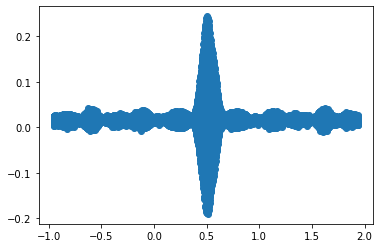

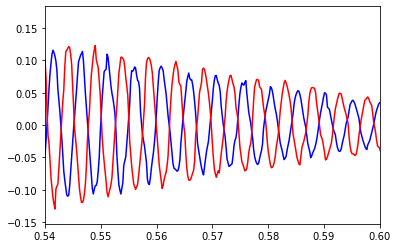

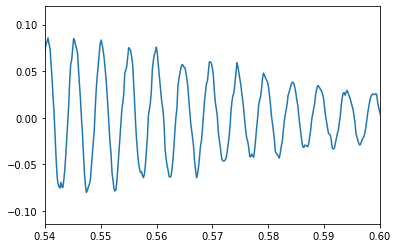

In [347]:
intfgms_arr=np.loadtxt('interferogram_arr.txt')
N=intfgms_arr.shape[1]

x,y=intfgms_arr[1][:N//2],intfgms_arr[0][:N//2]
x,y=zip(*sorted(zip(x,y)))
plt.figure()
plt.plot(x,y,marker='o',ls='-')
#plt.xlim(.8,.95)
    
IA = InterferogramAligner2(intfgms_arr)
intfg_aligned,x_aligned = IA(sign=1,Nwavelengths=1)

plt.figure()
plt.plot(x_aligned,IA.intfg_fwd,color='b')
plt.plot(x_aligned,IA.intfg_bwd,color='r')
plt.xlim(.54,.6)
d=0
#plt.axvline(IA.x_fwd+d,color='b')
#plt.axvline(IA.x_bwd+d,color='r')

plt.figure()
plt.plot(x_aligned,intfg_aligned)
print(intfg_aligned.max())
plt.xlim(.54,.6)
#plt.ax

0.12499757507823733


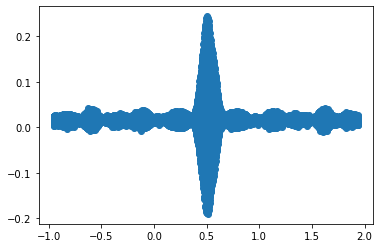

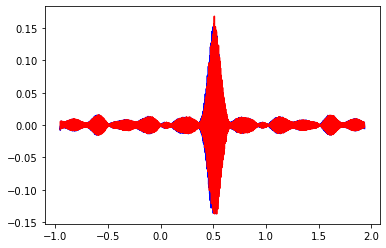

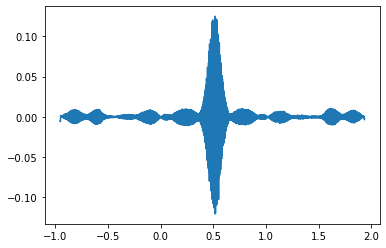

In [346]:
intfgms_arr=np.loadtxt('interferogram_arr.txt')
N=intfgms_arr.shape[1]

x,y=intfgms_arr[1][:N//2],intfgms_arr[0][:N//2]
x,y=zip(*sorted(zip(x,y)))
plt.figure()
plt.plot(x,y,marker='o',ls='-')
#plt.xlim(.8,.95)
    
IA = InterferogramAligner2(intfgms_arr)
intfg_aligned,x_aligned = IA(sign=-1,Nwavelengths=1)

plt.figure()
plt.plot(x_aligned,IA.intfg_fwd,color='b')
plt.plot(x_aligned,IA.intfg_bwd,color='r')
#plt.xlim(.54,.6)
d=0
#plt.axvline(IA.x_fwd+d,color='b')
#plt.axvline(IA.x_bwd+d,color='r')

plt.figure()
plt.plot(x_aligned,intfg_aligned)
print(intfg_aligned.max())
#plt.xlim(.54,.6)
#plt.ax

-0.7593043284111727
0.5242159572077254
4.999665021560688


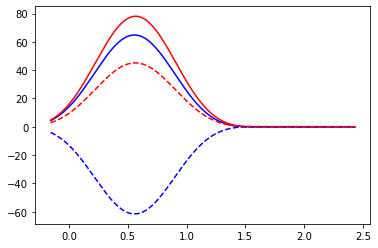

In [317]:
plt.plot(IA.xs, IA.env_fwd.real, color='b')
plt.plot(IA.xs, IA.env_bwd.real, color='r')
plt.plot(IA.xs, IA.env_fwd.imag, color='b',ls='--')
plt.plot(IA.xs, IA.env_bwd.imag, color='r',ls='--')
#plt.xlim(.54,.6)
p_fwd = np.angle(IA.env_fwd[4549])
p_bwd = np.angle(IA.env_bwd[4549])
                 
print(p_fwd)
print(p_bwd)
print( (p_fwd-p_bwd+2*np.pi) )

In [403]:
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import leastsq,minimize
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve as convolve
from common import numerics as num
from common import plotting
from scipy.stats import binned_statistic

class InterferogramAligner3(object):
    
    def regularized_intfg(self, intfgms_arr, fwd=True):

        assert len(intfgms_arr) % 2 == 0
        Nintfgms = len(intfgms_arr) // 2

        all_xs=[]
        all_ys=[]
        for i in range(Nintfgms):
            y, x = np.array(intfgms_arr[2 * i:2 * i + 2])
            N = len(x)
            
            if fwd:
                x = x[:N // 2]
                y = y[:N // 2]
            else:
                x = x[N // 2 :]
                y = y[N // 2 :]
                
            where_valid = (x != 0) * np.isfinite(x) * np.isfinite(y)
            all_xs += list(x[where_valid])
            all_ys += list(y[where_valid])
    
        stat = binned_statistic(all_xs, all_ys,
                                statistic='mean',
                                bins=len(all_xs) // Nintfgms,
                                range=(np.min(all_xs), np.max(all_xs)))

        ynew = stat.statistic
        xnew = stat.bin_edges[:-1]
        keep=np.isfinite(ynew)
        ynew=ynew[keep]
        xnew=xnew[keep]
                                       
        p = np.polyfit(x=xnew,y=ynew,deg=3)
        ynew -= np.polyval(x=xnew,p=p)                               
        
        return ynew,xnew
            
    def __init__(self, intfgms_arr):
        
        intfg_fwd, x_fwd = self.regularized_intfg(intfgms_arr, fwd=True)
        self.interp_fwd = interp1d(x=x_fwd, y=intfg_fwd, bounds_error=False,
                              fill_value=0, assume_sorted=True)
        intfg_bwd, x_bwd = self.regularized_intfg(intfgms_arr, fwd=False)
        self.interp_bwd = interp1d(x=x_bwd, y=intfg_bwd, bounds_error=False,
                              fill_value=0, assume_sorted=True)
                         
        xmin = np.max( (np.min(x_fwd), np.min(x_bwd)) )
        xmax = np.min( (np.max(x_fwd), np.max(x_bwd)) )              
        Nx = np.mean( (len(x_fwd), len(x_bwd)) )
        p=1
        while 2**p<Nx: p+=1
        Nx = 2**p
        self.xs = np.linspace(xmin, xmax, Nx)
        self.intfg_fwd =   self.interp_fwd(self.xs) 
        self.intfg_bwd =   self.interp_bwd(self.xs)                           
    
    def get_env(self,interferogram,Nwavelengths=10): #smooth over `Nwavelengths`
        
        if False in [hasattr(self,attr) for attr in ('Nx','w','fs')]:
            self.Nx=len(self.xs)
            self.w=np.blackman(self.Nx)
            self.fs = np.fft.fftfreq(self.Nx)

        interferogram = np.array(interferogram)
        self.interferogram = interferogram
        s = np.abs(np.fft.fft(interferogram*self.w))
        self.s = s
        self.f0 = np.abs(self.fs[np.argmax(s)]) #in case we pick up a negative frequency, doesnt matter
        
        inds=np.arange(self.Nx)
        self.sw = np.exp(1j*2*np.pi*self.f0*inds)
        window_len = 2*np.pi/(self.f0)*Nwavelengths
        window = np.blackman(window_len)
        interferogram_env=convolve(interferogram*self.sw,
                                     window,mode='same')
        
        return interferogram_env
    
    def __call__(self,order=16,Nwavelengths=2,**kwargs):
        
        p0=(0,)*order
        self.env_fwd = self.get_env(self.intfg_fwd,Nwavelengths=Nwavelengths)
        self.env_bwd = self.get_env(self.intfg_bwd,Nwavelengths=Nwavelengths)
        
        interp_env_fwd = interp1d(x=self.xs, y=np.abs(self.env_fwd), fill_value=0,bounds_error=False)
        interp_env_bwd = interp1d(x=self.xs, y=np.abs(self.env_bwd), fill_value=0,bounds_error=False)
        
        interp_fwd = interp1d(x=self.xs, y=self.intfg_fwd, fill_value=0,bounds_error=False)
        interp_bwd = interp1d(x=self.xs, y=self.intfg_bwd, fill_value=0,bounds_error=False)
        
        x=self.xs
        def to_minimize(p):
            
            self.xp_fwd = x-np.polyval(p,x=x)
            env_fwd_p=interp_env_fwd(self.xp_fwd)
            
            self.xp_bwd = x+np.polyval(p,x=x)
            env_bwd_p=interp_env_bwd(self.xp_bwd)
            
            return env_fwd_p-env_bwd_p
            
        from scipy.optimize import leastsq
        p=leastsq(to_minimize, p0)[0]
        
        self.intfg_fwd_aligned = interp_fwd(self.xp_fwd)
        self.intfg_bwd_aligned = interp_bwd(self.xp_bwd)
        intfg_aligned = np.mean( (self.intfg_fwd_aligned,
                                  self.intfg_bwd_aligned), axis=0)
        
        return intfg_aligned,self.xs

5.459130005204152
False
16384


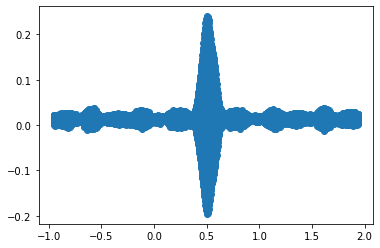

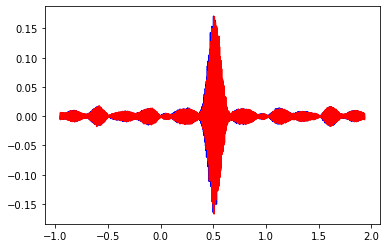

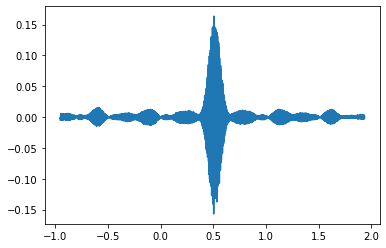

In [419]:
intfgms_arr=np.loadtxt('interferogram_arr.txt')
N=intfgms_arr.shape[1]

x,y=intfgms_arr[1][:N//2],intfgms_arr[0][:N//2]
x,y=zip(*sorted(zip(x,y)))
plt.figure()
plt.plot(x,y,marker='o',ls='-')
#plt.xlim(.8,.95)
    
IA = InterferogramAligner3(intfgms_arr)
intfg_aligned,x_aligned = IA(order=8,Nwavelengths=2)

plt.figure()
plt.plot(x_aligned,IA.intfg_fwd,color='b')
plt.plot(x_aligned,IA.intfg_bwd,color='r')
#plt.xlim(.54,.6)
d=0
#plt.axvline(IA.x_fwd+d,color='b')
#plt.axvline(IA.x_bwd+d,color='r')

plt.figure()
plt.plot(x_aligned,intfg_aligned)
print(np.sum(intfg_aligned**2))
#plt.xlim(.54,.6)
#plt.ax

print(np.nan in intfg_aligned or np.isinf in intfg_aligned)
print(len(intfg_aligned))

In [392]:
x=IA.xs
interp_env_fwd = interp1d(x=IA.xs, y=np.abs(IA.env_fwd), fill_value=0,bounds_error=False)
interp_env_bwd = interp1d(x=IA.xs, y=np.abs(IA.env_bwd), fill_value=0,bounds_error=False)
interp_fwd = interp1d(x=IA.xs, y=IA.intfg_fwd, fill_value=0,bounds_error=False)
interp_bwd = interp1d(x=IA.xs, y=IA.intfg_bwd, fill_value=0,bounds_error=False)

In [395]:
def get_env_fwd(p):
    
    xp = x+np.polyval(p,x=x)
    return interp_env_fwd(xp)

def get_env_bwd(p):
    
    xp = x-np.polyval(p,x=x)
    return interp_env_bwd(xp)

def get_fwd(p):
    
    xp = x+np.polyval(p,x=x)
    return interp_fwd(xp)

def get_bwd(p):
    
    xp = x-np.polyval(p,x=x)
    return interp_bwd(xp)

to_minimize = lambda p: get_env_fwd(p)-get_env_bwd(p)

from scipy.optimize import leastsq

p=leastsq(to_minimize,(0,0,0)*4)[0]
print(p)


    

[ 0.00075509 -0.00413169  0.00326436  0.01847144 -0.03408903 -0.00942585
  0.04715689 -0.00497913 -0.0238632   0.00396847  0.00237448 -0.00372751]


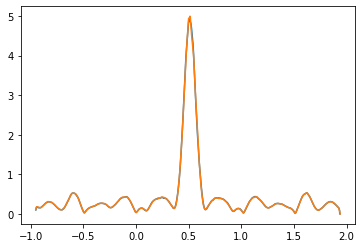

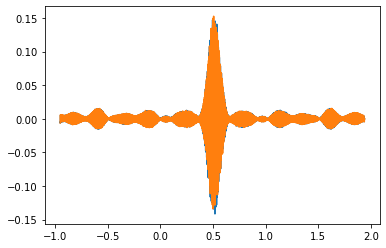

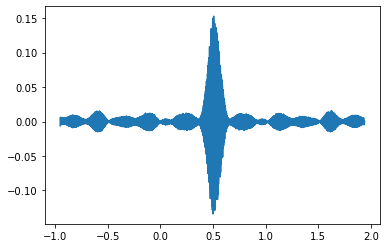

In [400]:
plt.figure()
plt.plot(x,get_env_fwd(p))
plt.plot(x,get_env_bwd(p))
#plt.xlim(.3,.6)

plt.figure()
plt.plot(x,get_fwd(p))
plt.plot(x,get_bwd(p))

plt.figure()
plt.plot(x,(get_bwd(p)+get_bwd(p))/2 )
